**Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb




Loading the data

In [2]:
df = pd.read_csv("Sales Records.csv")
df

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Order ID,Ship Date,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
0,Sub-Saharan Africa,South Africa,Fruits,Offline,M,7/27/2012,443368995,7/28/2012,1593,9.33,6.92,14862.69,11023.56,3839.13
1,Middle East and North Africa,Morocco,Clothes,Online,M,9/14/2013,667593514,10/19/2013,4611,109.28,35.84,503890.08,165258.24,338631.84
2,Australia and Oceania,Papua New Guinea,Meat,Offline,M,5/15/2015,940995585,6/4/2015,360,421.89,364.69,151880.40,131288.40,20592.00
3,Sub-Saharan Africa,Djibouti,Clothes,Offline,H,5/17/2017,880811536,7/2/2017,562,109.28,35.84,61415.36,20142.08,41273.28
4,Europe,Slovakia,Beverages,Offline,L,10/26/2016,174590194,12/4/2016,3973,47.45,31.79,188518.85,126301.67,62217.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,Sub-Saharan Africa,Senegal,Baby Food,Offline,L,11/6/2010,575470578,12/11/2010,3387,255.28,159.42,864633.36,539955.54,324677.82
999996,Central America and the Caribbean,Panama,Office Supplies,Offline,C,1/12/2015,766942107,3/1/2015,4068,651.21,524.96,2649122.28,2135537.28,513585.00
999997,Europe,Norway,Office Supplies,Online,M,10/25/2011,685472047,12/5/2011,5266,651.21,524.96,3429271.86,2764439.36,664832.50
999998,Europe,Montenegro,Beverages,Offline,M,10/31/2010,946734225,12/8/2010,8551,47.45,31.79,405744.95,271836.29,133908.66


In [3]:
df.columns

Index(['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority',
       'Order Date', 'Order ID', 'Ship Date', 'Units Sold', 'Unit Price',
       'Unit Cost', 'Total Revenue', 'Total Cost', 'Total Profit'],
      dtype='object')

EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Region          1000000 non-null  object 
 1   Country         1000000 non-null  object 
 2   Item Type       1000000 non-null  object 
 3   Sales Channel   1000000 non-null  object 
 4   Order Priority  1000000 non-null  object 
 5   Order Date      1000000 non-null  object 
 6   Order ID        1000000 non-null  int64  
 7   Ship Date       1000000 non-null  object 
 8   Units Sold      1000000 non-null  int64  
 9   Unit Price      1000000 non-null  float64
 10  Unit Cost       1000000 non-null  float64
 11  Total Revenue   1000000 non-null  float64
 12  Total Cost      1000000 non-null  float64
 13  Total Profit    1000000 non-null  float64
dtypes: float64(5), int64(2), object(7)
memory usage: 106.8+ MB


In [5]:
df.describe()

,Order ID,Units Sold,Unit Price,Unit Cost,Total Revenue,Total Cost,Total Profit
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1.000000e+06
mean,5.493520e+08,4998.867302,266.025488,187.522978,1.329563e+06,9.372671e+05,3.922956e+05
std,2.599397e+08,2885.334142,216.987966,175.650798,1.468527e+06,1.148954e+06,3.788199e+05
min,1.000012e+08,1.000000,9.330000,6.920000,9.330000e+00,6.920000e+00,2.410000e+00
25%,3.239629e+08,2502.000000,81.730000,35.840000,2.778672e+05,1.617289e+05,9.510480e+04
50%,5.486524e+08,4998.000000,154.060000,97.440000,7.844445e+05,4.667818e+05,2.810549e+05
75%,7.745981e+08,7496.000000,421.890000,263.330000,1.822444e+06,1.196327e+06,5.653076e+05
max,9.999999e+08,10000.000000,668.270000,524.960000,6.682700e+06,5.249600e+06,1.738700e+06


In [6]:
df.describe(include='object')

,Region,Country,Item Type,Sales Channel,Order Priority,Order Date,Ship Date
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,7,185,12,2,4,2767,2817
top,Sub-Saharan Africa,Panama,Fruits,Offline,C,11/25/2016,8/14/2015
freq,259953,5606,83551,500249,250313,430,420


Feature Enginnering

In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [8]:
df = df.sort_values('Order Date').reset_index(drop=True)

df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek
df['Quarter'] = df['Order Date'].dt.quarter
df['DayOfMonth'] = df['Order Date'].dt.day
df['WeekOfYear'] = df['Order Date'].dt.isocalendar().week

df['Shipping_Days'] = (df['Ship Date'] - df['Order Date']).dt.days

In [ ]:
for window in [7, 30]:
    df[f'Rolling_{window}d_Avg_Revenue'] = df.groupby('Region')['Total Revenue'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())
    df[f'Rolling_{window}d_Avg_Units'] = df.groupby('Region')['Units Sold'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

In [ ]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')
    
df    

Handling Duplicates

In [9]:
df.duplicated().sum()

np.int64(50009)

In [10]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

Encoding

In [11]:
le_dict = {}
for col in ['Region', 'Country', 'Item Type', 'Sales Channel', 'Order Priority']:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    le_dict[col] = le


Checking if there is sales with loss

In [16]:
df['Is_Loss'] = (df['Total Profit'] < 0).astype(int)
df['Is_Loss'].sum()

np.int64(0)

In [17]:
df.drop(columns=['Is_Loss'], inplace=True)


Correlation Matrix

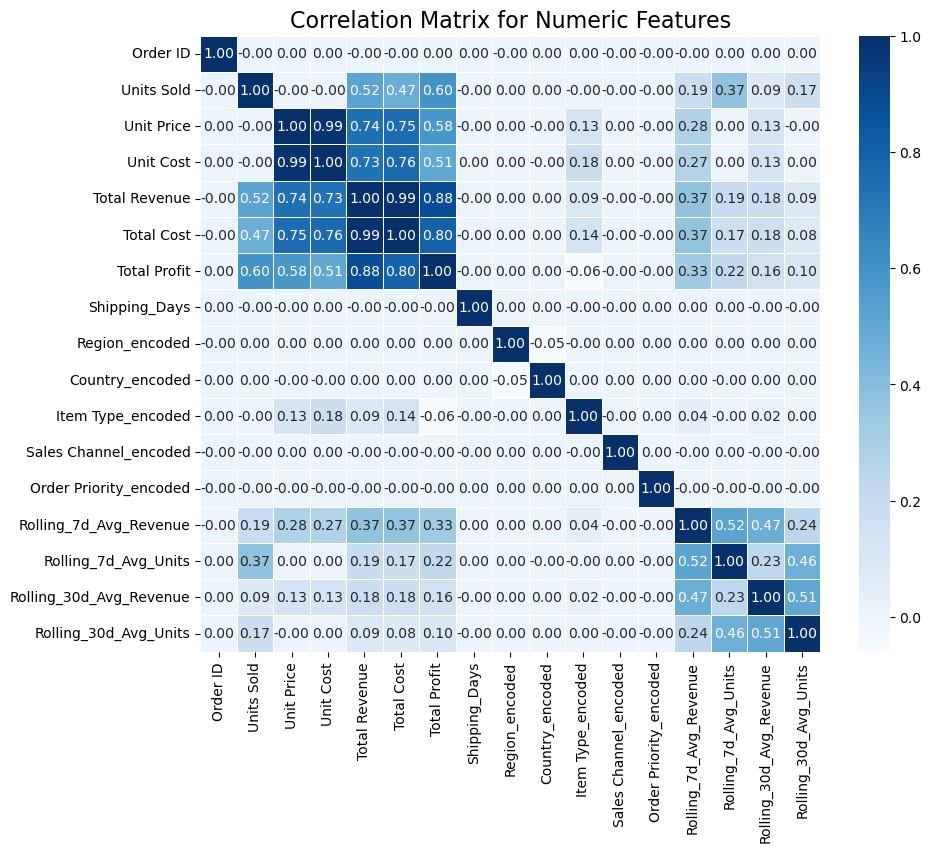

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Numeric Features', size=16)
plt.show()


In [29]:
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2017-07-29 00:00:00'))

**Prepare train-test split based on time**
:Training on the first 5 years (2010-2015) and testing on the last two years (2015-2017)


In [ ]:

train_end_date = df['Order Date'].max() - pd.DateOffset(years=2)
train_df = df[df['Order Date'] <= train_end_date]
test_df = df[df['Order Date'] > train_end_date]

Defining the X and Y features

In [21]:
feature_cols = [
    'Year', 'Month', 'DayOfWeek', 'Quarter', 'DayOfMonth', 'WeekOfYear',
    'Shipping_Days', 'Region_encoded', 'Country_encoded', 'Item Type_encoded',
    'Sales Channel_encoded', 'Order Priority_encoded', 'Unit Price', 'Unit Cost',
   
    'Rolling_7d_Avg_Revenue', 'Rolling_30d_Avg_Revenue',
   
]


In [22]:
X_train_rev = train_df[feature_cols]
y_train_rev = train_df['Total Revenue']
X_test_rev = test_df[feature_cols]
y_test_rev = test_df['Total Revenue']

**Modeling**

Linear Reagression

In [25]:
LR_model = LinearRegression()
LR_model.fit(X_train_rev, y_train_rev)

LinearRegression()

In [26]:
LR_model_pred = LR_model.predict(X_test_rev)

In [27]:
mae = mean_absolute_error(y_test_rev, LR_model_pred)
mse = mean_squared_error(y_test_rev, LR_model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rev, LR_model_pred)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 672306.4927796177
Mean Squared Error (MSE): 912495395013.5513
Root Mean Squared Error (RMSE): 955246.2483640285
R-squared: 0.5787035627332987


XGBRegressor

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(
    X_train_rev, y_train_rev,
    eval_set=[(X_test_rev, y_test_rev)],
    verbose=10
)


y_pred = model.predict(X_test_rev)

print("MAE:", mean_absolute_error(y_test_rev, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_rev, y_pred)))
print("R² Score:", r2_score(y_test_rev, y_pred))

[0]	validation_0-rmse:1425713.86413
[10]	validation_0-rmse:1114163.87112
[20]	validation_0-rmse:978600.68765
[30]	validation_0-rmse:925196.95818
[40]	validation_0-rmse:905318.11115
[50]	validation_0-rmse:898074.88930
[60]	validation_0-rmse:895458.14569
[70]	validation_0-rmse:894561.39905
[80]	validation_0-rmse:894294.46145
[90]	validation_0-rmse:894240.06835
[100]	validation_0-rmse:894241.66333
[110]	validation_0-rmse:894222.46017
[120]	validation_0-rmse:894250.22720
[130]	validation_0-rmse:894259.21727
[140]	validation_0-rmse:894350.18189
[150]	validation_0-rmse:894635.39637
[160]	validation_0-rmse:894818.05747
MAE: 602041.6954176237
RMSE: 894222.460168492
R² Score: 0.6308114250406007


In [ ]:

plot_importance(model)
plt.show()

LGBMRegressor

In [38]:
params_rev = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

model_rev = lgb.LGBMRegressor(**params_rev)
model_rev.fit(X_train_rev, y_train_rev)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.05, metric='rmse', objective='regression',
              verbose=-1)

In [39]:
rev_pred = model_rev.predict(X_test_rev)
rev_r2 = r2_score(y_test_rev, rev_pred)
rev_mae = mean_absolute_error(y_test_rev, rev_pred)
rev_rmse = np.sqrt(mean_squared_error(y_test_rev, rev_pred))

print("\nRevenue Prediction Results:")
print(f"R² Score: {rev_r2:.4f}")
print(f"MAE: {rev_mae:.2f}")
print(f"RMSE: {rev_rmse:.2f}")


Revenue Prediction Results:
R² Score: 0.6307
MAE: 602738.86
RMSE: 894384.49
